In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image
import jieba
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Load data
df_category = pd.read_csv('./categorize/categories.csv')
df_ingredient_category = pd.read_csv('./categorize/ingredient_category.csv')
df_method = pd.read_csv('./categorize/methods.csv')
df_effect = pd.read_csv('./categorize/effect.csv')

# 1. Recipe Category

### 1.1 Distribution of Recipe Category

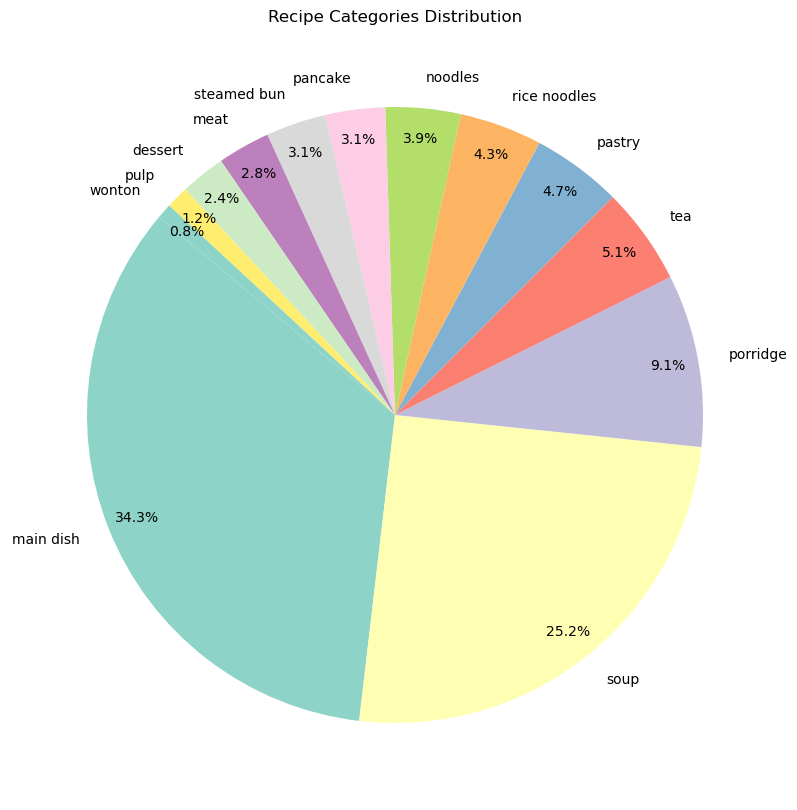

In [3]:
# Count frequency
category_count = df_category['category'].explode().value_counts()

# Create a pie chart "proportion of different ingredient categories"
plt.figure(figsize=(10, 10))
colors = sns.color_palette("Set3")
plt.pie(category_count, labels=category_count.index, colors=colors, autopct='%1.1f%%', startangle=140, pctdistance=0.9)
plt.title('Recipe Categories Distribution')
plt.show()

# 2. Ingredient

Merge all ingredients in different chapters into one dataframe, and create a wordcloud to show the overall distribution of all ingredients.

In [4]:
# Merge all ingredient data for further analysis
base_path = './ingredient_eng/'
files = os.listdir(base_path)
dfs = [pd.read_csv(os.path.join(base_path, file), sep='|') for file in files]
df_ingredient = pd.concat(dfs, ignore_index=True)

df_ingredient['Ingredient_en'] = df_ingredient['Ingredient_en'].replace("tsaoko cardamoms", "tsaoko cardamom")

Number of ingredients: 298


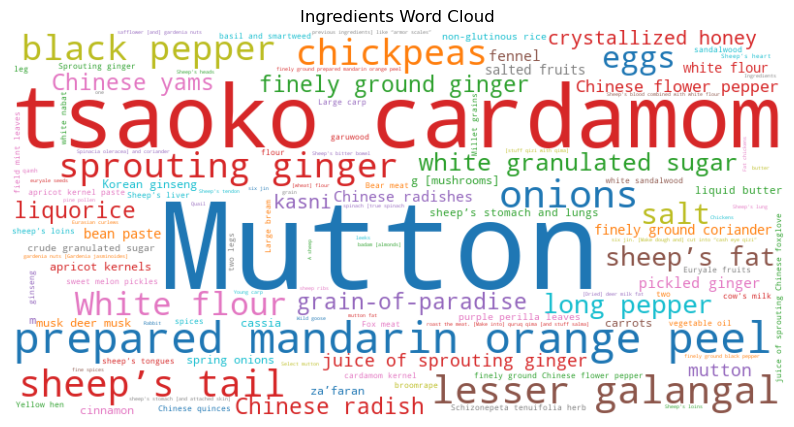

In [5]:
# Count frequency of ingredients
ingredient_count = df_ingredient['Ingredient_en'].explode().value_counts()
print(f"Number of ingredients: {len(ingredient_count)}")

# Create a wordcloud of all ingredients
wordcloud = WordCloud(width=800, height=400, colormap='tab10', background_color='rgba(255, 255, 255, 0)').generate_from_frequencies(ingredient_count)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Ingredients Word Cloud')
plt.show()

- the 20 most frequently used ingredients

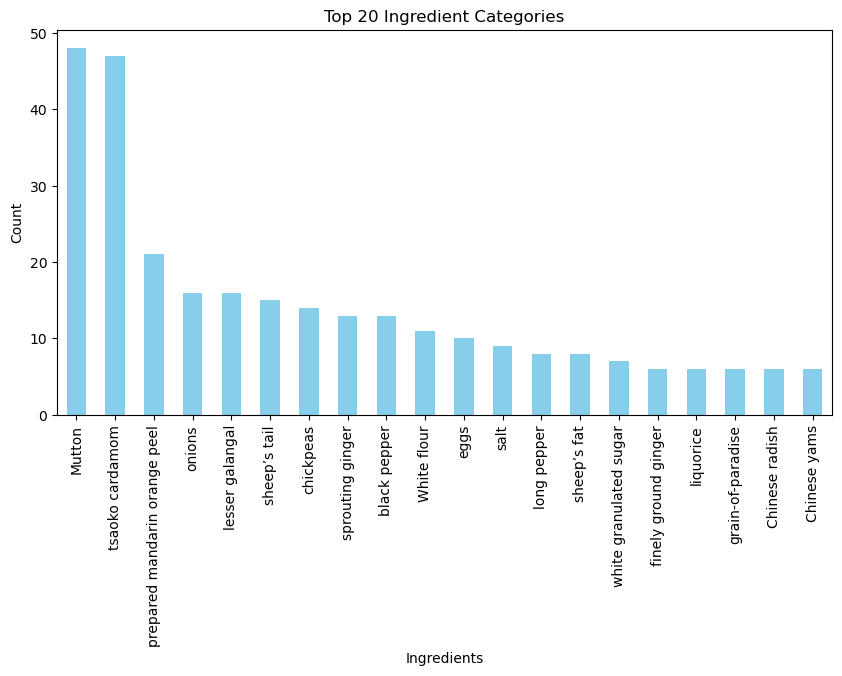

In [6]:
# Create a bar chart "top 20 most frequent ingredient categories"
plt.figure(figsize=(10, 5))
ingredient_count.head(20).plot(kind='bar', color='skyblue')
plt.title('Top 20 Ingredient Categories')
plt.xlabel('Ingredients')
plt.ylabel('Count')
plt.show()

### Ingredient Pairing (20 most frequent)

Count the frequency of co-occurrence of ingredients in recipes, and display the top 30 pairs of ingredients with the highest co-occurrence frequency in the heatmap.

In [7]:
# Define co_occurrence_matrix function
def Cal_co_occurrence_matrix(column):
    # Create a CountVectorizer to calculate co-occurrence matrix
    def phrase_analyzer(text):
        return text.split('  ')
    vectorizer = CountVectorizer(analyzer=phrase_analyzer, binary=True)
    co_occurrence_matrix = vectorizer.fit_transform(column)

    # Convert the sparse matrix to a DataFrame
    co_occurrence_df = pd.DataFrame(co_occurrence_matrix.toarray(), columns=vectorizer.get_feature_names_out())

    # Calculate the co-occurrence matrix
    co_occurrence_matrix = co_occurrence_df.T.dot(co_occurrence_df)
    co_occurrence_matrix.values[np.diag_indices_from(co_occurrence_matrix)] = 0  # Set diagonal elements to zero
    
    return co_occurrence_matrix

In [8]:
# Concatenate ingredients for each food_name
grouped_df = df_ingredient.groupby('Food_Name_en')['Ingredient_en'].apply(lambda x: '  '.join(x)).reset_index()

# Calculate the co_occurrence matrix
co_occurrence_matrix = Cal_co_occurrence_matrix(grouped_df['Ingredient_en'])

# Extract the top 30 component pairs with the highest co-occurrence frequency from the co-occurrence matrix
top_ingredients = co_occurrence_matrix.unstack().sort_values(ascending=False)[:30]

# Create a DataFrame from the 'pairing' Series
top_ingredients_df = pd.Series(top_ingredients).reset_index(name='count')

# Pivot the DataFrame to make it suitable for heatmap
heatmap_data = top_ingredients_df.pivot(index='level_0', columns='level_1', values='count')

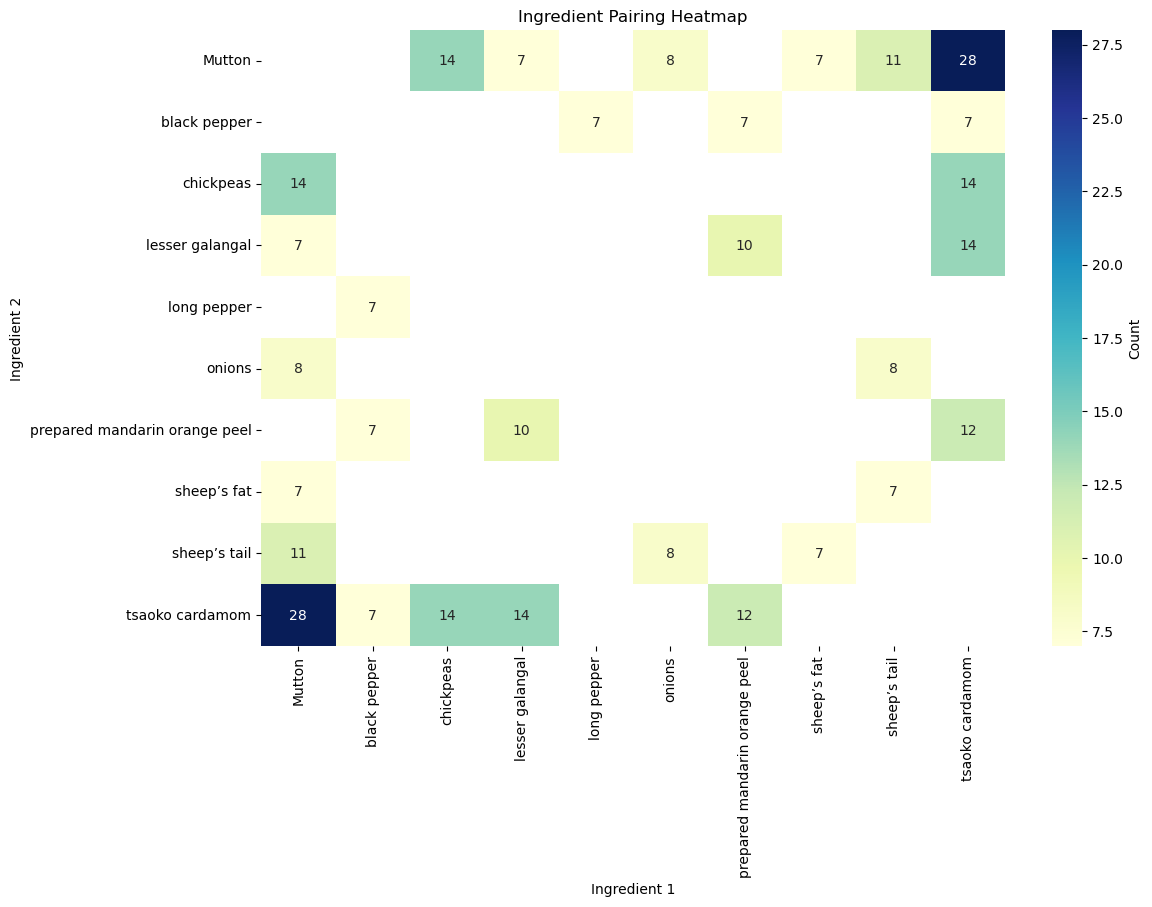

In [9]:
# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt='g', cbar_kws={'label': 'Count'})
plt.xlabel('Ingredient 1')
plt.ylabel('Ingredient 2')
plt.title('Ingredient Pairing Heatmap')
plt.show()

### Ingrediant category

Categorize the ingredients into 13 defined categories, and analyze data based on the ingredient categories.

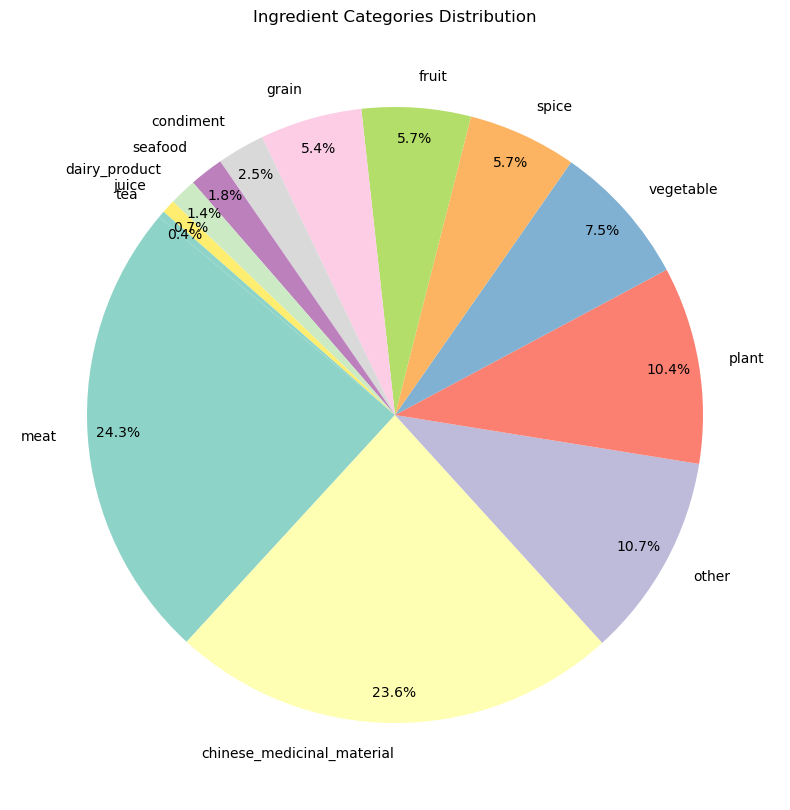

In [10]:
# Count frequency of ingredient categories
ingredient_category_count = df_ingredient_category['catagory'].explode().value_counts()

# Create a pie chart "proportion of different ingredient categories"
plt.figure(figsize=(10, 10))
colors = sns.color_palette("Set3")
plt.pie(ingredient_category_count, labels=ingredient_category_count.index, colors=colors, autopct='%1.1f%%', startangle=140, pctdistance=0.9) #, explode=(0,0,0,0,0,0,0,0,0,0,0,0.01,0.01))
plt.title('Ingredient Categories Distribution')
plt.show()

### Ingredient categories pairing

In [11]:
# Merge data 'ingredient', 'ingredient_category'
ingredient_combined = pd.merge(df_ingredient, df_ingredient_category, on='Ingredient', how='left')

# Concatenate ingredients for each food_name
grouped_df = ingredient_combined.groupby('Food_Name')['catagory'].apply(lambda x: ' '.join(x.astype(str))).reset_index()

# Create a CountVectorizer to calculate co-occurrence matrix
vectorizer = CountVectorizer(analyzer='word', binary=True)
co_occurrence_matrix = vectorizer.fit_transform(grouped_df['catagory'])

# Convert the sparse matrix to a DataFrame
co_occurrence_df = pd.DataFrame(co_occurrence_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Calculate the co-occurrence matrix
co_occurrence_matrix = co_occurrence_df.T.dot(co_occurrence_df)
co_occurrence_matrix.values[np.diag_indices_from(co_occurrence_matrix)] = 0  # Set diagonal elements to zero

In [12]:
# Normalize data
normalized_matrix = normalize(co_occurrence_matrix)
normalized_df = pd.DataFrame(normalized_matrix, columns=co_occurrence_matrix.columns, index=co_occurrence_matrix.index)

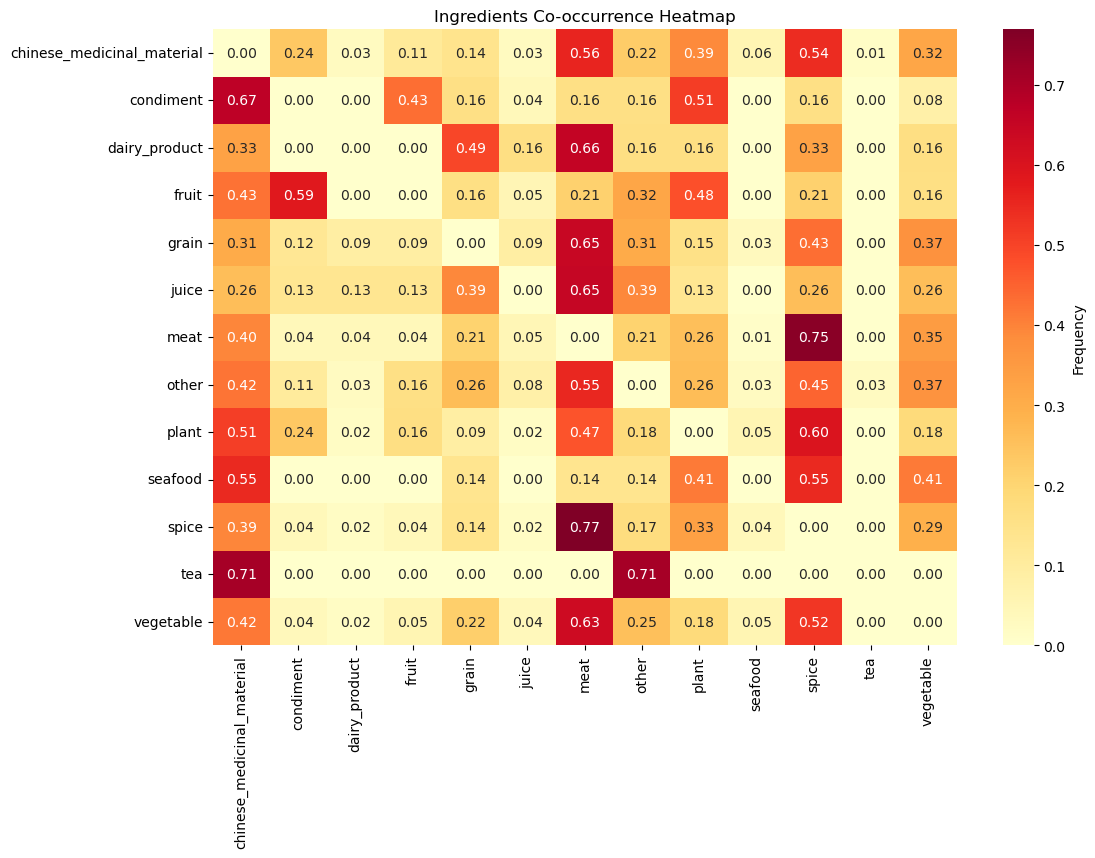

<Figure size 640x480 with 0 Axes>

In [13]:
# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(normalized_df, cmap="YlOrRd", annot=True, fmt=".2f", cbar_kws={'label': 'Frequency'})
plt.title('Ingredients Co-occurrence Heatmap')
plt.show()

# 3. Cooking Method

In [14]:
# Map the cooking methods from Chinese to English
method_mapping = {'煮': 'Boil', '蒸': 'Steam', '熬': 'Simmer', '煎': 'Pan-fry', '炸': 'Fry', '焙': 'Bake', 
                  '淹': 'Marinate', '炙': 'Broil', '炒': 'Stir-fry', '烧': 'Fire'}

# Mapping 'method' from Chinese to English
df_method['method'] = df_method['method'].replace(method_mapping)

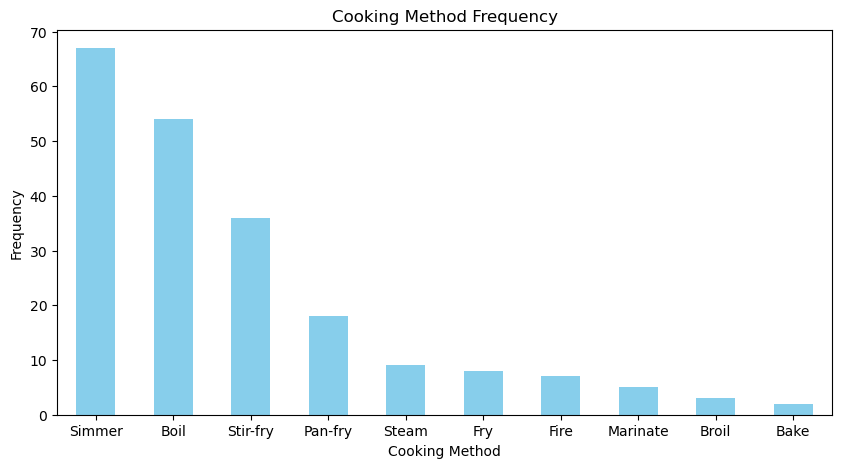

In [15]:
# Count frequency of cooking methods
method_count = df_method['method'].explode().value_counts()

# Create a bar chart "Cooking Methods"
plt.figure(figsize=(10, 5))
method_count.plot(kind='bar', color='skyblue')
plt.title('Cooking Method Frequency')
plt.xlabel('Cooking Method')
plt.ylabel('Frequency')
plt.xticks(rotation=0) 
plt.show()

# 4. Effect

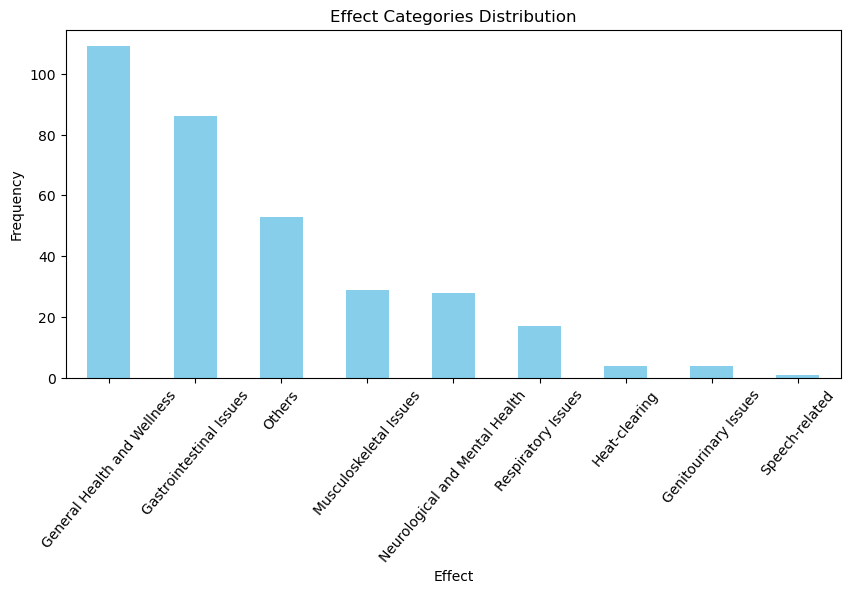

In [16]:
# Count frequency of effects
effect_count = df_effect['Category'].explode().value_counts()

# Create a bar chart "Top 10 Effect Categories"
plt.figure(figsize=(10, 6))
effect_count.head(10).plot(kind='bar', color='skyblue')
plt.title('Effect Categories Distribution')
plt.xlabel('Effect')
plt.ylabel('Frequency')
plt.xticks(rotation=50)
plt.subplots_adjust(bottom=0.3) # set bottom margin
plt.show()

### Effect - Ingredient Correlation

In [17]:
# Merge 'ingredients' and 'effects' on 'Food_Name'
merged_df = pd.merge(df_effect, df_ingredient, on='Food_Name')

# Finding the top 10 most frequent ingredients and effect categories
top_ingredients = df_ingredient['Ingredient_en'].value_counts().head(20).index
top_categories = df_effect['Category'].value_counts().head(6).index

# Filtering the merged dataframe to include only rows with top ingredients and top categories
filtered_df = merged_df[merged_df['Ingredient_en'].isin(top_ingredients) & merged_df['Category'].isin(top_categories)]

# Creating a pivot table for the heatmap with the filtered data
filtered_pivot_table = pd.pivot_table(filtered_df, values='Food_Name', index='Ingredient_en', columns='Category', 
                                      aggfunc='count', fill_value=0)
top_categories

Index(['General Health and Wellness', 'Gastrointestinal Issues', 'Others',
       'Musculoskeletal Issues', 'Neurological and Mental Health',
       'Respiratory Issues'],
      dtype='object')

In [18]:
# Normalize data
normalized_table = normalize(filtered_pivot_table, norm='l2', axis=0)
normalized_df = pd.DataFrame(normalized_table, columns=filtered_pivot_table.columns, index=filtered_pivot_table.index)

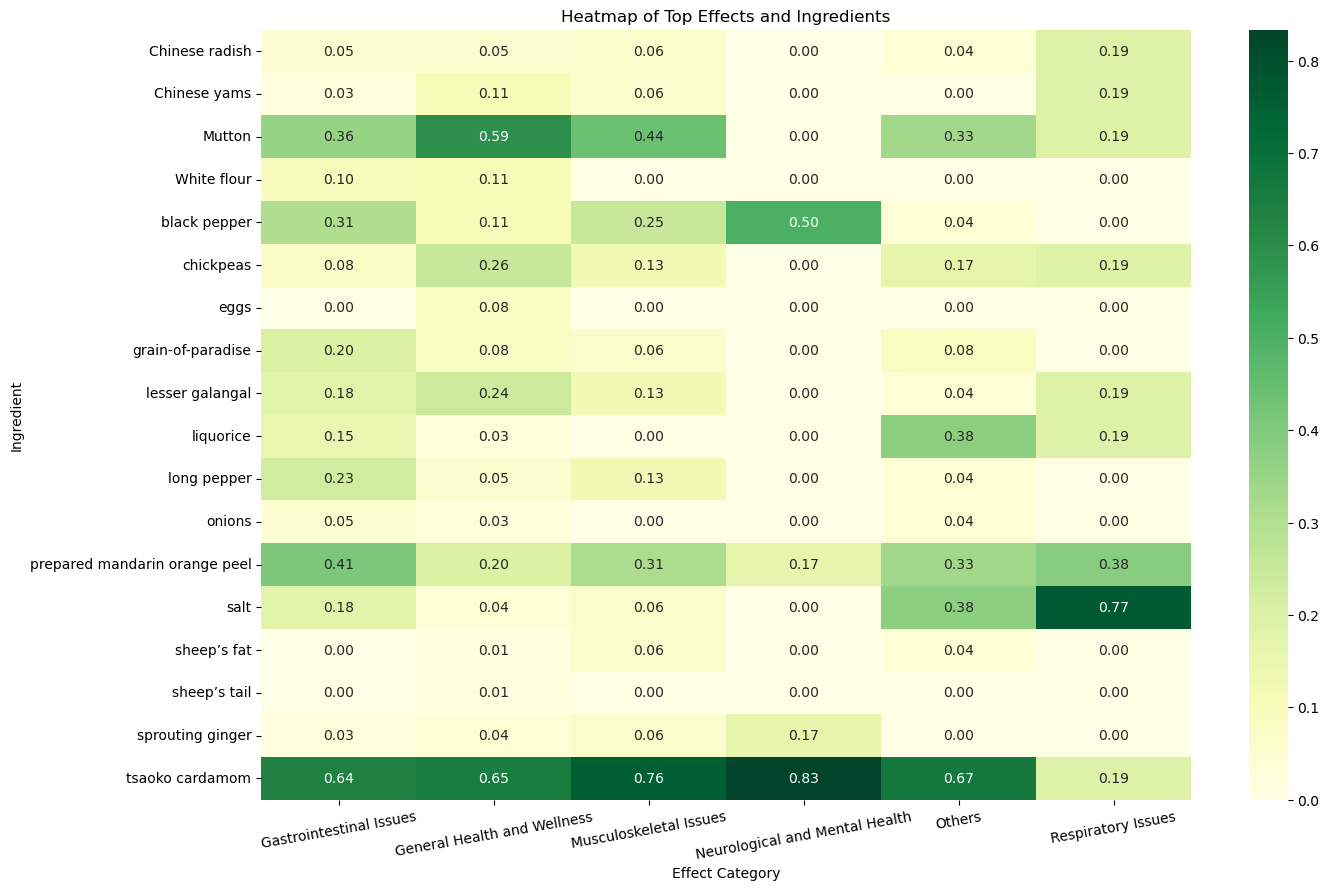

In [19]:
# Create a heatmap with filtered data
plt.figure(figsize=(15, 10))
sns.heatmap(normalized_df, annot=True, fmt=".2f", cmap="YlGn")
plt.title('Heatmap of Top Effects and Ingredients')
plt.xlabel('Effect Category')
plt.ylabel('Ingredient')
plt.xticks(rotation=10)
plt.yticks(rotation=0)
# plt.subplots_adjust(bottom=0.3) # set bottom margin
# Save image
filename = "./Viz/Heatmap of Top Effects and Ingredients.png"
plt.savefig(filename, transparent=True)
plt.show()